In [1]:
import os
import glob
import pandas as pd
import numpy as np
  
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
all_Acq_files = glob.glob(os.path.join("Acquisition*.txt"))

In [3]:
df_from_each_file = (pd.read_csv(f,sep ="|", index_col=None, header=None) for f in all_Acq_files)
df = pd.concat(df_from_each_file, ignore_index=True)

In [4]:
## The files don't have names for each column so add the columns here
##
df.rename(columns={
                    0: 'Loan_ID',
                    1: 'Channel',
                    2: 'Seller',
                    3: 'Interest_Rate',
                    4: 'UPB',
                    5: 'Loan_Term',
                    6: 'Origination_Date',
                    7: 'First_Payment_Date',
                    8: 'LTV',
                    9: 'CLTV',
                    10: 'Num_Borrowers',
                    11: 'DTI',
                    12: 'Borrower_FICO',
                    13: 'First_Time_Buyer',
                    14: 'Loan_Purpose',
                    15: 'Dwelling_Type',
                    16: 'Unit_Count',
                    17: 'Occupancy',
                    18: 'State',
                    19: 'Zip',
                    20: 'Insurance%',
                    21: 'Product',
                    22: 'Co_Borrower_FICO',
                    23: 'Mortgage_Insurance_Type',
                    24: 'Relocation_Indicator'}, inplace=True)

In [5]:
## Now grab a listing of all the performance files in the RawData directory
##
all_perf_files = glob.glob(os.path.join( "Performance_*.txt"))

In [6]:
## read in the data from each of the performance files and concatenate the
## data together into a single dataframe names "perf_df" and while we're reading the data in only include
## the columns we actually want for this analysis.
##
df_from_each_file = (pd.read_csv(f,sep ="|", index_col=None, header=None
                                 ,usecols=[0,1,3,4,5,11,12]
                                 , names = ['Loan_ID', 'Period', 'Current_IR','Current_UPB', 'Age',
                                            'Mod_Ind','Zero_Bal_Cd']
                                 ,dtype = { 'Loan_ID' : np.int64, 'Current_IR' : np.float64, 
                                           'Current_UPB': np.float64}
                                ) for f in all_perf_files)
perf_df   = pd.concat(df_from_each_file, ignore_index=True)

In [7]:
## Modify the date field ("Period") to be a number for easier manipulation
## later on in the script
## 
perf_df['Period']=perf_df['Period'].apply(str).str[6:].apply(int)*100+perf_df['Period'].apply(str).str[:2].apply(int)

## Select the latest period in the data frame as we're concerned with the most recent loan status
##
idx = perf_df.groupby(['Loan_ID'])['Period'].transform(max) == perf_df['Period']

## Create a new data frame with just the latest period record
## 
perf_df_new = perf_df[idx].copy()


In [8]:
## In looking at the FAQ dor the datasets we know that if the zero balance code is null then the loan is current
## meaning it's paid up correctly. It's not late, or paid off early, or in default so we don't really care
## about those records as regards our analysis.
##
perf_df_new.Zero_Bal_Cd.fillna(0,inplace=True)

## Also, some of the loans are missing the UPB (unpaid balance). We can't use that data in building our model
## so we'll just drop those loans from the dataframe
##
perf_df_new.dropna(inplace=True)

## create a mapping of the available zero_balance_code numbers and their meanings
##
zero_bal_cd_map = {0:'Current',1:'Prepaid',2:'Third Party Sale',3:'Short Sale',
                   6:'Repurchase',9:'REO',15:'Note Sale',16:'RPL Loan Sale'}
perf_df_new['Zero_Bal_Cd'] = perf_df_new['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)

## display a listing of the updated performance data 
##
perf_df_new.head()

,Loan_ID,Period,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd
81,100002679724,201906,3.625,110549.80,82,N,Current
150,100003137281,201805,3.375,147781.08,68,N,Prepaid
234,100004790326,201906,4.125,219852.60,84,N,Current
268,100006404894,201504,3.000,123368.58,33,N,Prepaid
305,100008536293,201508,3.250,159596.31,36,N,Prepaid


In [9]:
## Now that we've cleaned up the acquisition and performance data, merge them into a single integrated
## data frame that we'll call "loan_df"
##
loan_df = pd.merge(df,perf_df_new,how='inner',on='Loan_ID')

## display the first several rows from the combined dataset
##
loan_df.head()

,Loan_ID,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,...,Product,Co_Borrower_FICO,Mortgage_Insurance_Type,Relocation_Indicator,Period,Current_IR,Current_UPB,Age,Mod_Ind,Zero_Bal_Cd
0,100001458647,R,"CITIMORTGAGE, INC.",5.625,297000,360,05/2004,07/2004,49,61.0,...,FRM,NaN,NaN,N,201309,5.625,251567.64,111,N,Prepaid
1,100004788186,C,"BANK OF AMERICA, N.A.",5.750,50000,180,08/2004,10/2004,25,25.0,...,FRM,753.0,NaN,N,201207,5.750,12621.76,94,N,Prepaid
2,100008528816,R,OTHER,5.000,80000,180,08/2004,10/2004,75,75.0,...,FRM,678.0,NaN,N,201508,5.000,40214.78,131,N,REO
3,100014656651,C,"BANK OF AMERICA, N.A.",6.300,55000,240,07/2004,09/2004,80,80.0,...,FRM,NaN,NaN,N,201402,6.300,37473.50,114,N,Prepaid
4,100021529837,C,"BANK OF AMERICA, N.A.",5.875,140000,360,07/2004,09/2004,80,80.0,...,FRM,794.0,NaN,N,201010,5.875,119759.31,74,N,Prepaid


In [10]:
loan_df.isnull().sum()

Loan_ID                          0
Channel                          0
Seller                           0
Interest_Rate                    0
UPB                              0
Loan_Term                        0
Origination_Date                 0
First_Payment_Date               0
LTV                              0
CLTV                             4
Num_Borrowers                   65
DTI                          40037
Borrower_FICO                 3450
First_Time_Buyer                 0
Loan_Purpose                     0
Dwelling_Type                    0
Unit_Count                       0
Occupancy                        0
State                            0
Zip                              0
Insurance%                 1678310
Product                          0
Co_Borrower_FICO           1017720
Mortgage_Insurance_Type    1678310
Relocation_Indicator             0
Period                           0
Current_IR                       0
Current_UPB                      0
Age                 

In [11]:
## Assign Defaults for the missing values in the loans dataframe
##
loan_df.Mortgage_Insurance_Type.fillna(0,inplace=True)
loan_df['Insurance%'].fillna(0,inplace=True)
loan_df.Num_Borrowers.fillna(1,inplace=True)
loan_df.CLTV.fillna(loan_df.LTV,inplace=True)
loan_df.drop('Co_Borrower_FICO',axis=1,inplace=True)

In [12]:
## We'll do some analysis against the FICO (credit score) of the borrower
## Create several bins based on the FICO score range and add the calculated FICO bin score
## to each record in the dataframe
##
FICO_bins = [0,620,660,700,740,780,850]
FICO_labels = ['0-620', '620-660','660-700','700-740','740-780','780+']
loan_df['FICO_bins'] = pd.cut(loan_df['Borrower_FICO'],bins=FICO_bins,labels=FICO_labels)

Term_bins =[0,180,360]
Term_labels =['<=15 Years','<= 30 Years']
loan_df['Term_bins'] = pd.cut(loan_df['Loan_Term'],bins=Term_bins,labels=Term_labels)

zero_bal_cd_map = {'Current':'Current','Prepaid':'Prepaid','Third Party Sale':'Underperforming','Short Sale':'Underperforming',
                   'Repurchase':'Underperforming','REO':'Underperforming','Note Sale':'Underperforming','RPL Loan Sale':'Underperforming'}

loan_df['Current_Status'] = loan_df['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)


loan_df['Origin_Month'],loan_df['Origin_Year'] = loan_df['First_Payment_Date'].str.split('/', 1).str

df = loan_df[loan_df['Origin_Year'].isin(['2003','2008','2012','2016'])]

In [13]:
## Create a new dataframe that holds the first 100,000 records
##
df2 = df.groupby('Origin_Year').head(100000)

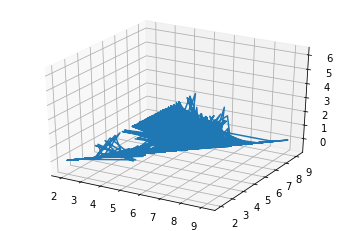

In [14]:
risk = df2.Interest_Rate - df2.Current_IR
fig = plt.figure()
ax = plt.axes(projection = "3d")
X, Y, Z = df2.Interest_Rate, df2.Current_IR, risk
ax.plot3D(X, Y, Z)
plt.show()

In [15]:
## display another table showing the total number of each status by year
##
df2.groupby(['Origin_Year','Current_Status']).agg({'Loan_ID':'count'})

Loan_ID
Origin_Year Current_Status          
2003        Current              279
            Prepaid             3882
            Underperforming       56
2008        Current             7217
            Prepaid            86951
            Underperforming     5832
2012        Current            53763
            Prepaid            46080
            Underperforming      157
2016        Current            82544
            Prepaid            17356
            Underperforming      100

In [105]:
delta_IR = df2.Interest_Rate - df2.Current_IR
df2['delta_IR'] = delta_IR
subset = df2.loc[(df2.delta_IR!=0)]

/Users/shivangi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


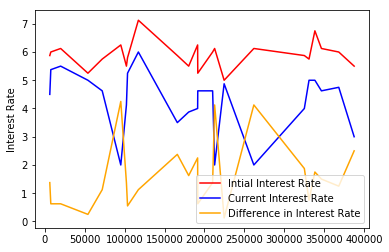

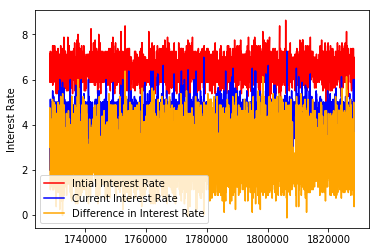

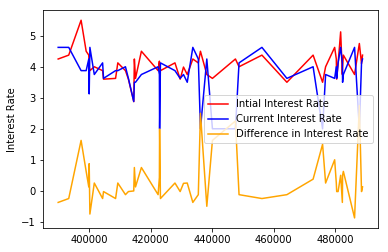

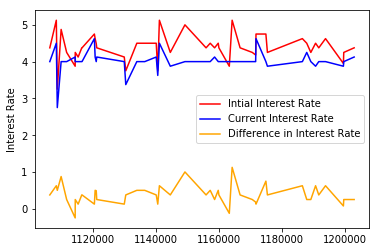

In [107]:
risk_factor = subset.groupby('Origin_Year')
dictonary = {}
for delta_IR, group in risk_factor:
    f = plt.figure()
    plt.plot(group.Interest_Rate, color = 'red', label = 'Intial Interest Rate')
    plt.plot(group.Current_IR, color = 'blue', label = 'Current Interest Rate')
    plt.plot(group.delta_IR, color = 'orange', label = 'Difference in Interest Rate')
    #plt.title('Original Year = 'delta_IR, fontweight='bold')
    plt.ylabel('Interest Rate')
    plt.legend()
    plt.show()

       
#plt.plot(subset.Current_IR)
#plt.plot(subset.Interest_Rate)
#plt.show()

In [108]:
bar = df2.groupby(['Origin_Year','FICO_bins', 'Current_Status']).agg({'Loan_ID' : 'count'})
print(bar)
data = pd.DataFrame.from_dict(bar.to_dict()).Loan_ID
data_2003 = data[:18]
data_2008 = data[18:36]
data_2012 = data[36:54]
data_2016 = data[54:]
        

                                       Loan_ID
Origin_Year FICO_bins Current_Status          
2003        0-620     Current               17
                      Prepaid              122
                      Underperforming        8
            620-660   Current               17
                      Prepaid              216
                      Underperforming       17
            660-700   Current               45
                      Prepaid              431
                      Underperforming       10
            700-740   Current               53
                      Prepaid              732
                      Underperforming        6
            740-780   Current               87
                      Prepaid             1290
                      Underperforming       10
            780+      Current               56
                      Prepaid             1063
                      Underperforming        4
2008        0-620     Current              467
             

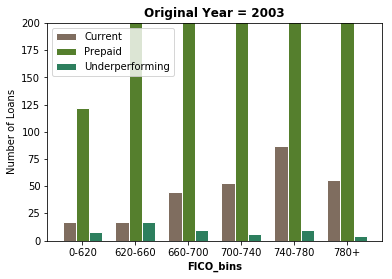

In [51]:
barWidth = 0.25

# Set height of bar
b1 = [data_2003[i] for i in range(0, len(data_2003),3)]
b2 = [data_2003[i] for i in range(1, len(data_2003),3)]
b3 = [data_2003[i] for i in range(2, len(data_2003),3)]

# Set position of bar on X axis
r1 = np.arange(len(b1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
y_axis = ['0-620', '620-660','660-700','700-740','740-780','780+']

# Make the plot
figure1 = plt.figure()
plt.bar(r1,b1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Current')
plt.bar(r2,b2, color='#557f2d', width=barWidth, edgecolor='white', label='Prepaid')
plt.bar(r3,b3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Underperforming')
 
# Add xticks on the middle of the group bars

plt.title('Original Year = 2003', fontweight='bold')
plt.xlabel('FICO_bins', fontweight='bold')
plt.ylabel('Number of Loans')
plt.xticks([r + barWidth for r in range(len(b1))],['0-620', '620-660','660-700','700-740','740-780','780+'])
plt.ylim(0, 200)
 
# Create legend & Show graphic
plt.legend()
plt.show()
figure1.savefig('plot1.png')

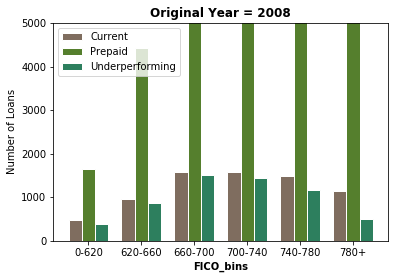

In [44]:
# Set height of bar
c1 = [data_2008[i] for i in range(0, len(data_2008),3)]
c2 = [data_2008[i] for i in range(1, len(data_2008),3)]
c3 = [data_2008[i] for i in range(2, len(data_2008),3)]

# Set position of bar on X axis
r1 = np.arange(len(c1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
y_axis = ['0-620', '620-660','660-700','700-740','740-780','780+']

# Make the plot
figure2 = plt.figure()
plt.bar(r1,c1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Current')
plt.bar(r2,c2, color='#557f2d', width=barWidth, edgecolor='white', label='Prepaid')
plt.bar(r3,c3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Underperforming')
 
# Add xticks on the middle of the group bars
plt.title('Original Year = 2008', fontweight='bold')
plt.xlabel('FICO_bins', fontweight='bold')
plt.ylabel('Number of Loans')
plt.xticks([r + barWidth for r in range(len(c1))],['0-620', '620-660','660-700','700-740','740-780','780+'])
plt.ylim(0, 5000)

# Create legend & Show graphic
plt.legend()
plt.show()
figure2.savefig('plot2.png')

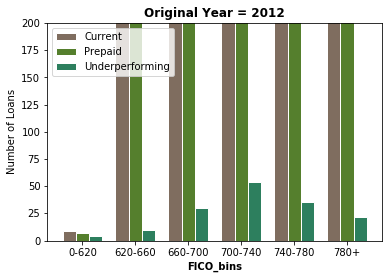

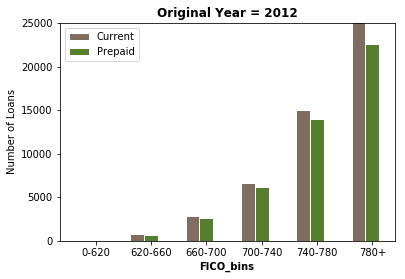

In [58]:
# Set height of bar
d1 = [data_2012[i] for i in range(0, len(data_2012),3)]
d2 = [data_2012[i] for i in range(1, len(data_2012),3)]
d3 = [data_2012[i] for i in range(2, len(data_2012),3)]

# Set position of bar on X axis
r1 = np.arange(len(d1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
y_axis = ['0-620', '620-660','660-700','700-740','740-780','780+']

# Make the plot
figure3 = plt.figure()
plt.bar(r1,d1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Current')
plt.bar(r2,d2, color='#557f2d', width=barWidth, edgecolor='white', label='Prepaid')
plt.bar(r3,d3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Underperforming')
 
# Add xticks on the middle of the group bars
plt.title('Original Year = 2012', fontweight='bold')
plt.xlabel('FICO_bins', fontweight='bold')
plt.ylabel('Number of Loans')
plt.xticks([r + barWidth for r in range(len(d1))],['0-620', '620-660','660-700','700-740','740-780','780+'])
plt.ylim(0, 200)
 
# Create legend & Show graphic
plt.legend()
plt.show()
figure3.savefig('plot3.png')


figure6 = plt.figure()
plt.bar(r1,d1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Current')
plt.bar(r2,d2, color='#557f2d', width=barWidth, edgecolor='white', label='Prepaid')

 #Add xticks on the middle of the group bars
plt.title('Original Year = 2012', fontweight='bold')
plt.xlabel('FICO_bins', fontweight='bold')
plt.ylabel('Number of Loans')
plt.xticks([r + barWidth for r in range(len(d1))],['0-620', '620-660','660-700','700-740','740-780','780+'])
plt.ylim(0, 25000)
 
# Create legend & Show graphic
plt.legend()
plt.show()
figure6.savefig('plot6.png')

[40, 908, 2166, 3398, 4764, 6092] [18, 11, 25, 30, 21, 13] [2661, 7717, 14425, 23700, 33972]


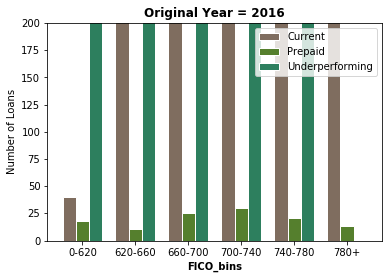

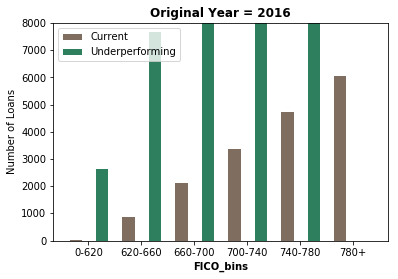

In [49]:
# Set height of bar

e1 = [data_2016[i] for i in range(0, len(data_2016),3)]
e2 = [data_2016[i] for i in range(1, len(data_2016),3)]
e3 = [data_2016[i] for i in range(2, len(data_2016),3)]
print(e1,e2,e3)
e3.append(0)

# Set position of bar on X axis
r1 = np.arange(len(e1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
y_axis = ['0-620', '620-660','660-700','700-740','740-780','780+']

# Make the plot
figure4 = plt.figure()
plt.bar(r1,e1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Current')
plt.bar(r2,e2, color='#557f2d', width=barWidth, edgecolor='white', label='Prepaid')
plt.bar(r3,e3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Underperforming')
 
# Add xticks on the middle of the group bars
plt.title('Original Year = 2016', fontweight='bold')
plt.xlabel('FICO_bins', fontweight='bold')
plt.ylabel('Number of Loans')
plt.xticks([r + barWidth for r in range(len(e1))],['0-620', '620-660','660-700','700-740','740-780','780+'])
plt.ylim(0, 200) 
# Create legend & Show graphic
plt.legend()
plt.show()
figure4.savefig('plot4.png')

figure5 = plt.figure()
plt.bar(r1,e1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Current')
plt.bar(r3,e3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Underperforming')
# Add xticks on the middle of the group bars
plt.title('Original Year = 2016', fontweight='bold')
plt.xlabel('FICO_bins', fontweight='bold')
plt.ylabel('Number of Loans')
plt.xticks([r + barWidth for r in range(len(e1))],['0-620', '620-660','660-700','700-740','740-780','780+'])
plt.ylim(0, 8000) 
# Create legend & Show graphic
plt.legend()
plt.show()
figure5.savefig('plot5.png')


In [22]:
#Calculationg the amount of down payment
down_payment = df.UPB * ((100/df.LTV)-1)
df2['initial_payment'] = down_payment


/Users/shivangi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
## Write our current data frame out to a file. This will allow us to pick up and continue our
## analysis without going through all the previous work to clean and structure
## the data correctly.
##
df2.to_csv('Processed_loans.csv',index=False)

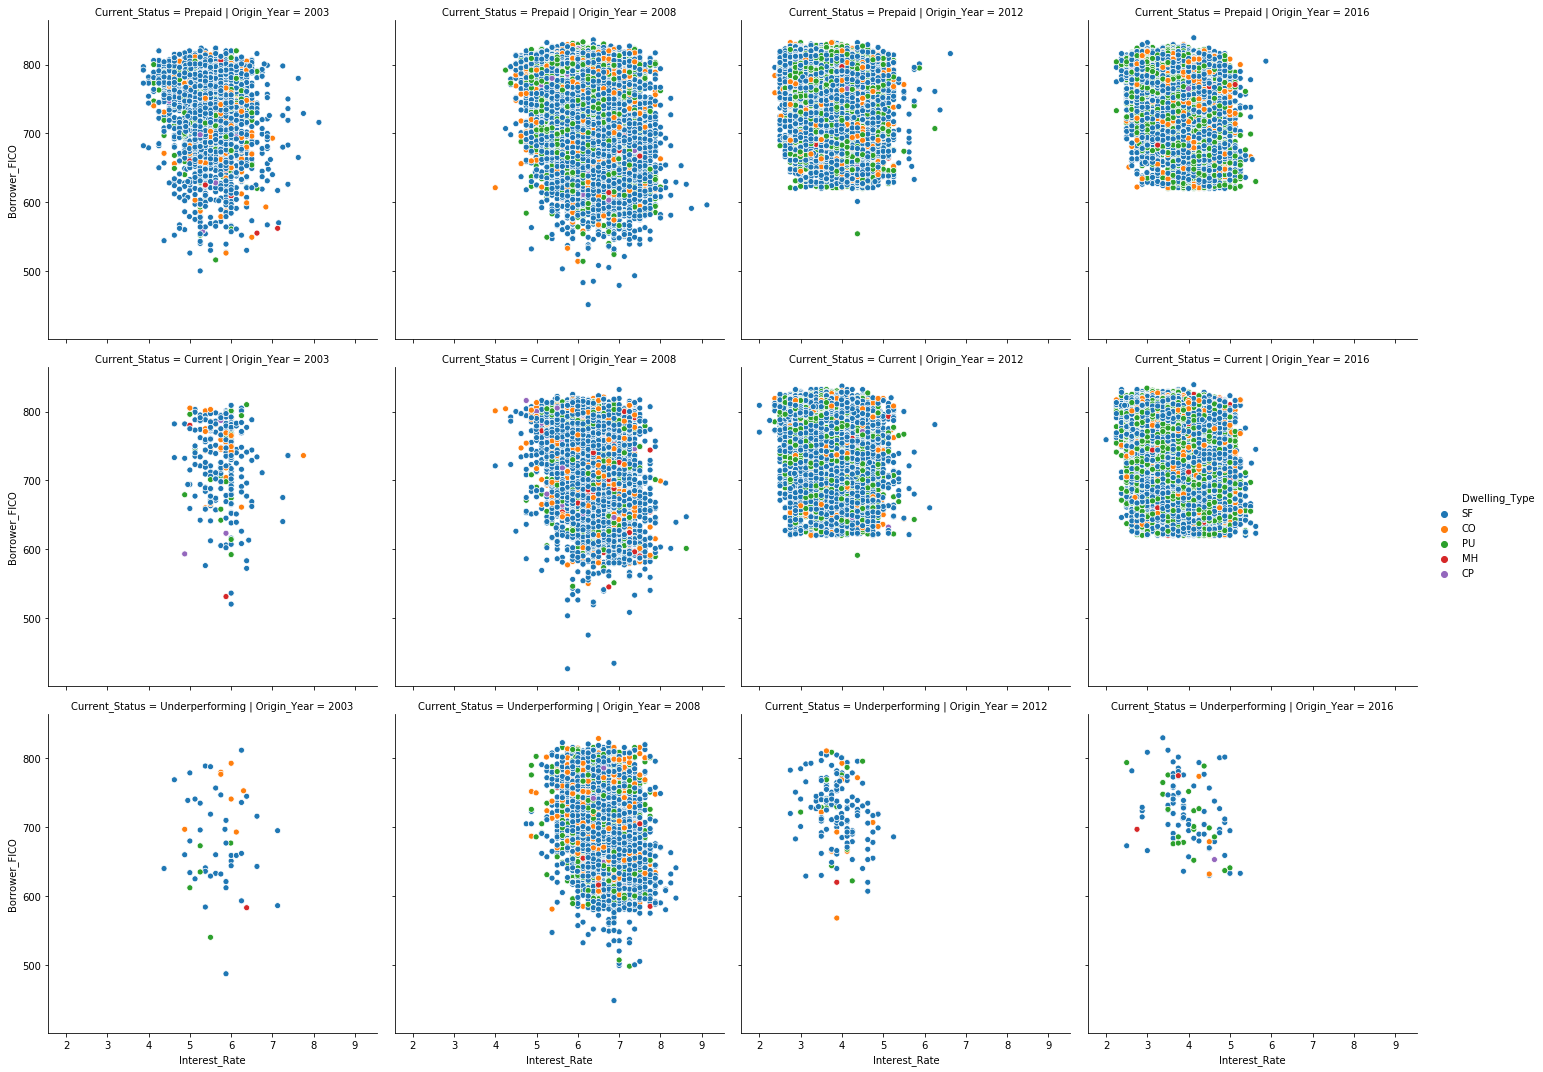

In [24]:
## Create and display a plot showing the distribution by year for the Borrower FICO score vs
## current, underperforming, and prepaid (paid off early) loans
##
sns.relplot(y='Borrower_FICO', x='Interest_Rate', data=df2
            ,hue='Dwelling_Type',
            row='Current_Status', col='Origin_Year')
plt.show()

In [25]:
## Rebalance the record set by Dwelling Type into a new data frame (df3). We're doing this because the Single
## Family data (individual family homes) is far larger than the other types of homes (multi-family, etc) and we want
## a more balanced view of the data. You could go back and do a deeper analysis by home type and look for risk
## factors on that basis, or by zip code, number of borrowers, etc...
##
g = df2.groupby(['Origin_Year','Dwelling_Type'])

df3 = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

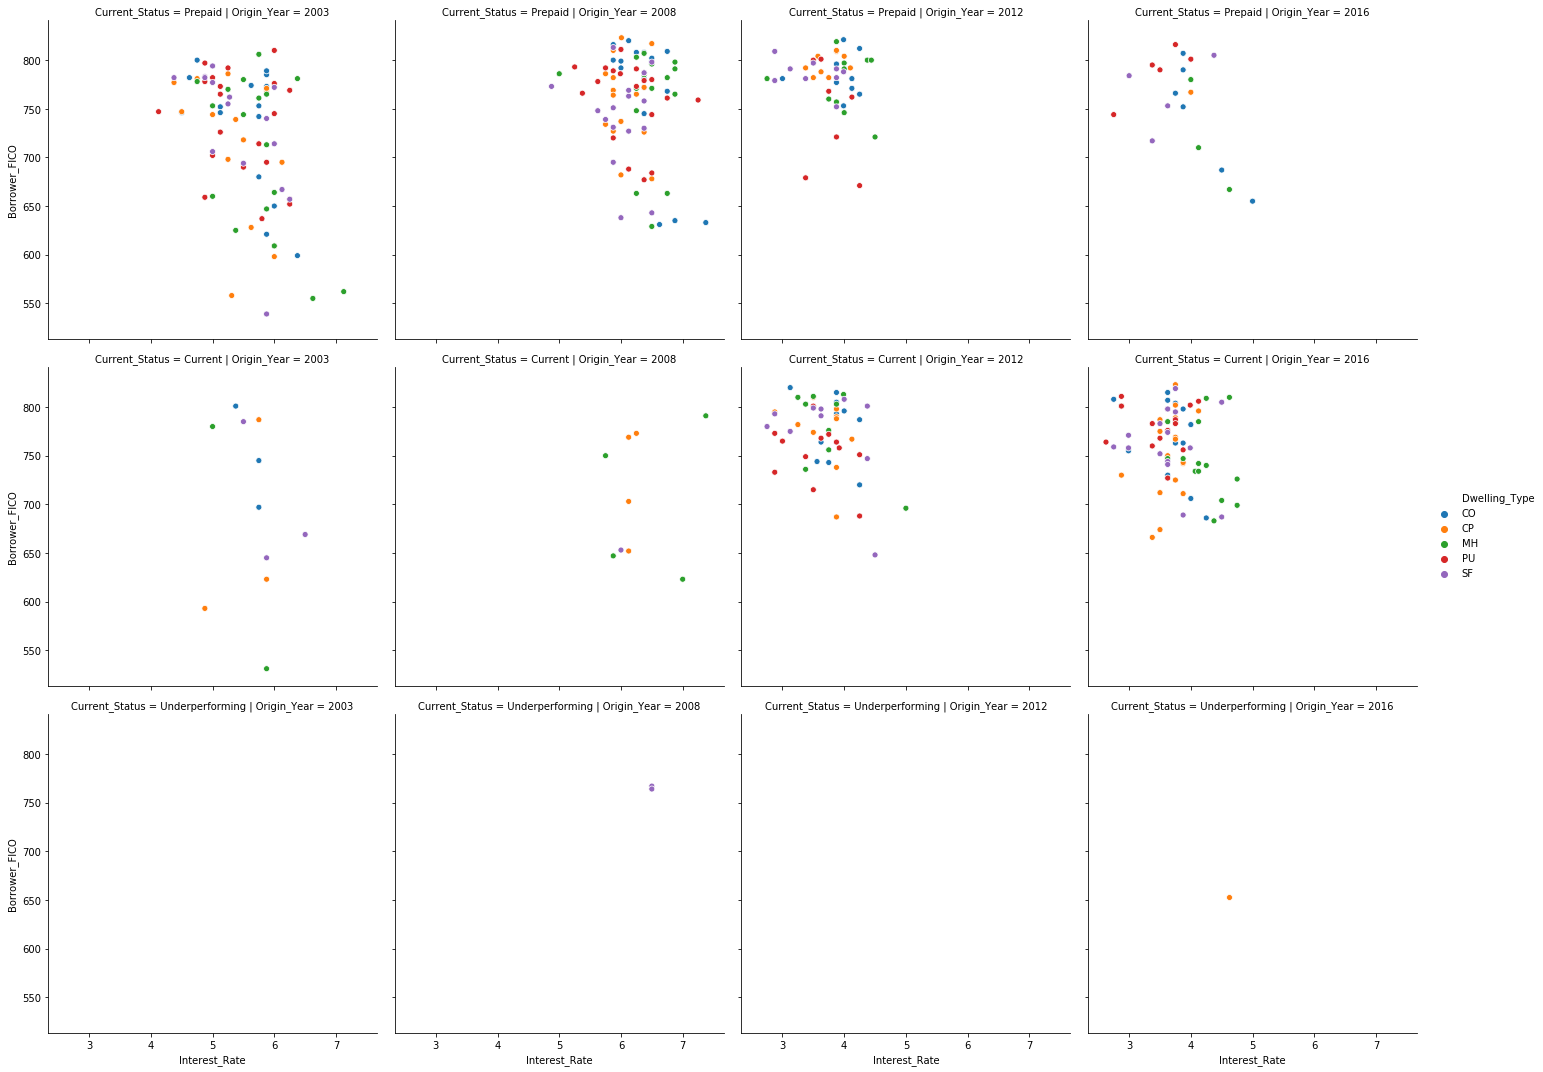

In [26]:
## Redisplay the graph based on the same attributes used above
##
sns.relplot(y='Borrower_FICO', x='Interest_Rate', data=df3#.query('Current_Status != "Prepaid"'), #kind='line', 
            ,hue='Dwelling_Type',
            row='Current_Status', col='Origin_Year')
plt.show()

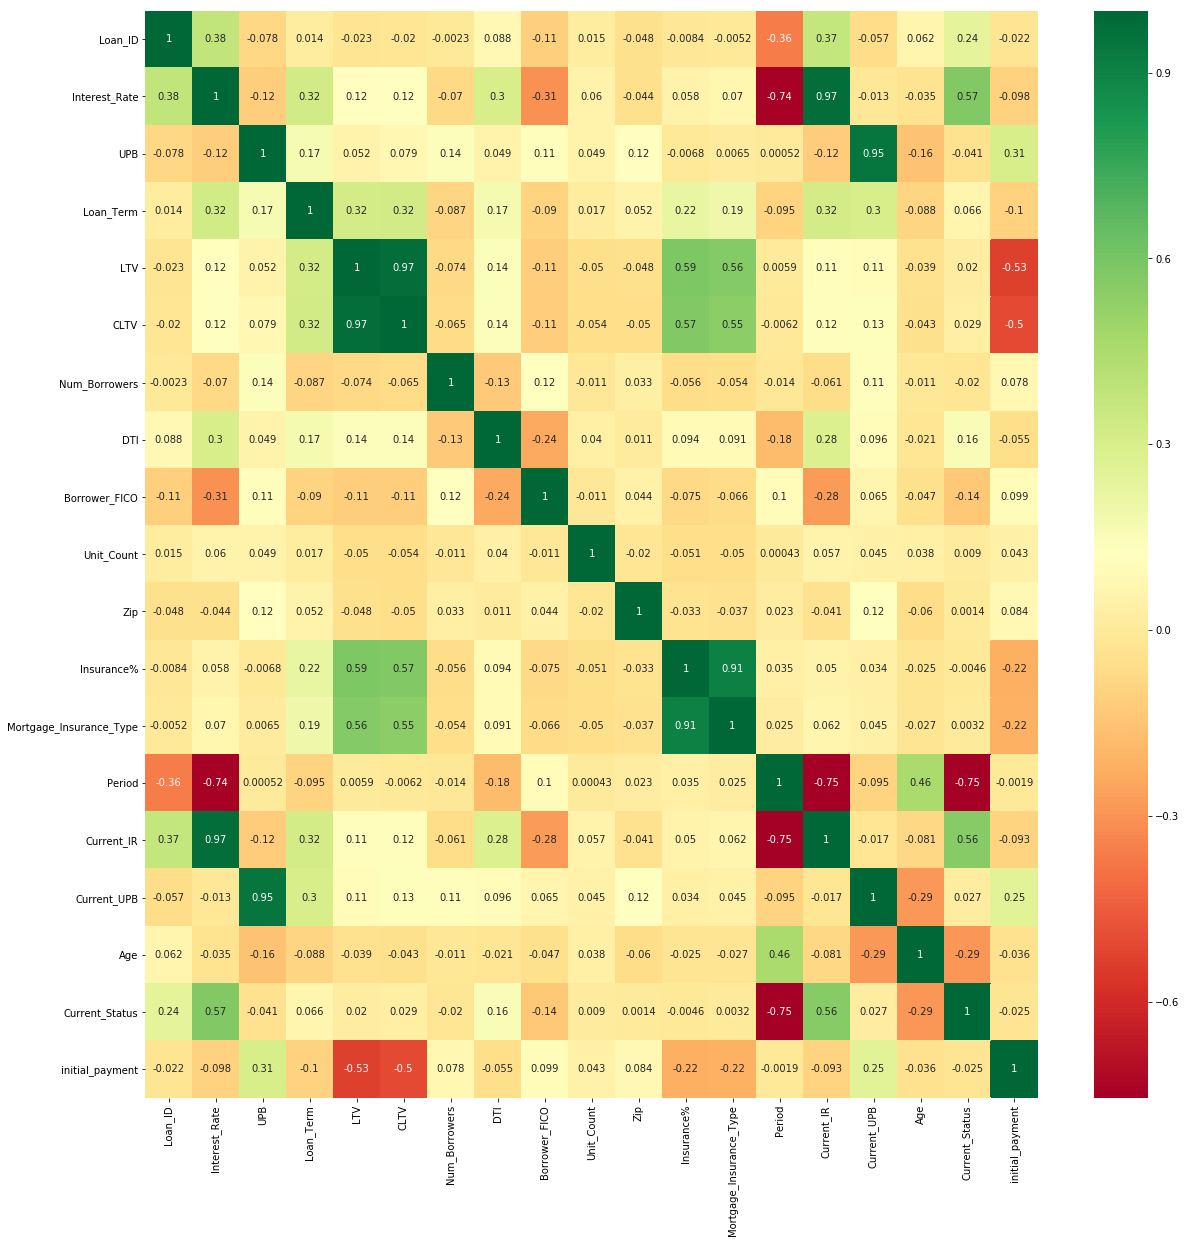

In [31]:
loan=df2.copy()
loan['Current_Status']=loan['Current_Status'].astype('category').cat.codes
#X = loan.iloc[:,0:34]  #independent columns
#y = loan.iloc[:,-1]    #target column i.e price
#get correlations of each features in dataset
corrmat = loan.corr()
top_corr_features = corrmat.index
fig1 = plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(loan[top_corr_features].corr(),annot=True,cmap="RdYlGn")
fig1.savefig('corr_matrix.png')

In [116]:
#df3.var('Interest_Rate','UPB','Loan_Term','LTV','Num_Borrowers','Borrower_FICO',axis=0)
np.log(df3.var(axis=0))

Loan_ID                    52.158753
Interest_Rate               0.359737
UPB                        23.378144
Loan_Term                   8.785589
LTV                         5.740311
CLTV                        5.701943
Num_Borrowers              -1.342842
DTI                         4.796582
Borrower_FICO               8.045098
Unit_Count                 -5.940171
Zip                        11.697694
Insurance%                  4.483312
Mortgage_Insurance_Type    -1.890844
Period                     12.153957
Current_IR                  0.362976
Current_UPB                23.305609
Age                         7.588569
initial_payment            25.071172
dtype: float64